In [1]:
from utils import get_data, knn2laplacian, dfs_search
from zlap import create_separate_graph
import numpy as np
import cupy as cp

from sklearn.manifold import TSNE

from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
from openTSNE import TSNE

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# function to obatin the full inverse of Laplacian (used only for tsne plotting)

def get_full_Linv(features, clf, k, gamma, alpha, scale_sim=False):
    num_classes = clf.shape[0]
    knn, sim = create_separate_graph(features, clf, k)

    xmin = None
    xmax = None
    if scale_sim:
        xmin = np.min(sim[knn != -1])
        xmax = np.max(sim[knn != -1])
        sim = (sim - xmin) / (xmax - xmin)
    sim[sim < 0] = 0

    mask_knn = knn < num_classes
    sim[mask_knn] = sim[mask_knn] ** gamma
    L = knn2laplacian(knn, sim, alpha)

    scores = cp.zeros((num_classes + features.shape[0], num_classes + features.shape[0]))
    for idx in range(num_classes + features.shape[0]):
        Y = cp.zeros((L.shape[0],))
        Y[idx] = 1
        out = dfs_search(L, Y, cast_to_numpy=False)
        scores[idx, :] = out.copy()

    return scores.get(), xmin, xmax

In [3]:
def TSNE_(X, 
          affinities=None, 
          normalize_affinities=True, 
          perplexity=30, 
          n_iter_ex1=250, 
          n_iter_ex2=100, 
          exaggeration=12):
    '''
    # see openTSNE reference for params: 
    # https://opentsne.readthedocs.io/en/latest/examples/02_advanced_usage/02_advanced_usage.html

    '''
    if affinities is None:
        affinities = affinity.PerplexityBasedNN(X, perplexity=perplexity, metric="cosine", n_jobs=8, random_state=seed, verbose=True)
    else:
        print("USING PRECOMPUTED")
        affinities = affinity.PrecomputedAffinities(affinities, normalize=normalize_affinities)        
    init_train = initialization.pca(X, random_state=seed)
    embedding_train = TSNEEmbedding(init_train, affinities, negative_gradient_method="fft", n_jobs=8, verbose=True)
    embedding_train_1 = embedding_train.optimize(n_iter=n_iter_ex1, exaggeration=exaggeration)
    embedding_train_2 = embedding_train_1.optimize(n_iter=n_iter_ex2)
    return embedding_train_2

def plot_tsne(X_2d_all, K_classes, classifier_marker_size=50, feature_marker_size=15, targets_selected=None):
    K = len(K_classes)
    cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:K])
    print(f"Color that is used: {cmap(0)}")
    
    cls_2d = X_2d_all[:K,:]
    img_2d = X_2d_all[K:,:]
      
    fig = plt.figure(figsize=(10, 7))

    for i in range(K):
        c = K_classes[i]
        print(cmap(i))
        for f_idx in np.where(targets_selected == c)[0]:
            plt.scatter(img_2d[f_idx, 0], img_2d[f_idx, 1], s=feature_marker_size, color=cmap(i))
        plt.scatter(cls_2d[i, 0], cls_2d[i, 1], s=classifier_marker_size, marker='*',color=cmap(i))
    plt.axis('off')
        
    return fig

In [4]:
(
    train_features,
    train_targets,
    val_features,
    val_targets,
    test_features,
    test_targets,
    clf_text,
    clf_image_train,
    clf_image_val,
    clf_image_test,
    clf_cupl_text,
    clf_cupl_image_train,
    clf_cupl_image_val,
    clf_cupl_image_test,
) = get_data("cub", "RN50_openai")

No test features! Using val features as test!
No InMaP classifer learned on test, so using the one trained on val instead!
No InMaP classifer learned on test, so using the one trained on val instead!


In [5]:
C = clf_text.shape[0]
N = test_features.shape[0]

#limit data to K classes, M images per class
K = 5
M = 20

seed = 43

np.random.seed(seed)
K_classes = np.random.choice(C, K, replace=False)
print(f' - Keeping only {K} classes: {K_classes}, with {M} images each')

features_selected = []
indices_selected = []
targets_selected = []
for ii, k in enumerate(K_classes):
    class_ind = np.where(test_targets == k)[0]
    class_ind = class_ind[:min(M, len(class_ind))]
    indices_selected.append(class_ind)
    features_selected.append(test_features[class_ind,:])
    targets_selected.append(np.ones(len(class_ind))*k)

features_selected = np.concatenate(features_selected, axis=0)
targets_selected = np.concatenate(targets_selected).astype(int)
indices_selected = np.concatenate(indices_selected).astype(int)
clf_text_selected = clf_text[K_classes,:]
print(' - selected features:', features_selected.shape)
print(' - selected classifiers:', clf_text_selected.shape)

 - Keeping only 5 classes: [56 37 67 79 80], with 20 images each
 - selected features: (100, 1024)
 - selected classifiers: (5, 1024)


In [6]:
Linv, _, _ = get_full_Linv(test_features, clf_text, 5, 5.0, 0.3)

In [7]:
X = np.vstack([clf_text_selected, features_selected])
all_indices_selected = np.concatenate([K_classes, indices_selected+clf_text.shape[0]])
Linv_selected = Linv[np.ix_(all_indices_selected, all_indices_selected)]

===> Finding 90 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=8.75 for 450 iterations...
Iteration   50, KL divergence 1.1241, 50 iterations in 0.2822 sec
Iteration  100, KL divergence 1.1241, 50 iterations in 0.2746 sec
Iteration  150, KL divergence 1.1241, 50 iterations in 0.2745 sec
Iteration  200, KL divergence 1.1241, 50 iterations in 0.2749 sec
Iteration  250, KL divergence 1.1241, 50 iterations in 0.2750 sec
Iteration  300, KL divergence 1.1241, 50 iterations in 0.2747 sec
Iteration  350, KL divergence 1.1241, 50 iterations in 0.2747 sec
Iteration  400, KL divergence 1.1241, 50 iterations in 0.2749 sec
Iteration  450, KL divergence 1.1241, 50 iterations in 0.2746 sec
   --> Time elapsed: 2.48 seconds
===> Running optimization with exaggeration=1.00, lr=105.00 for 50 iterations...
Iteration   50, KL divergenc

<IPython.core.display.Javascript object>


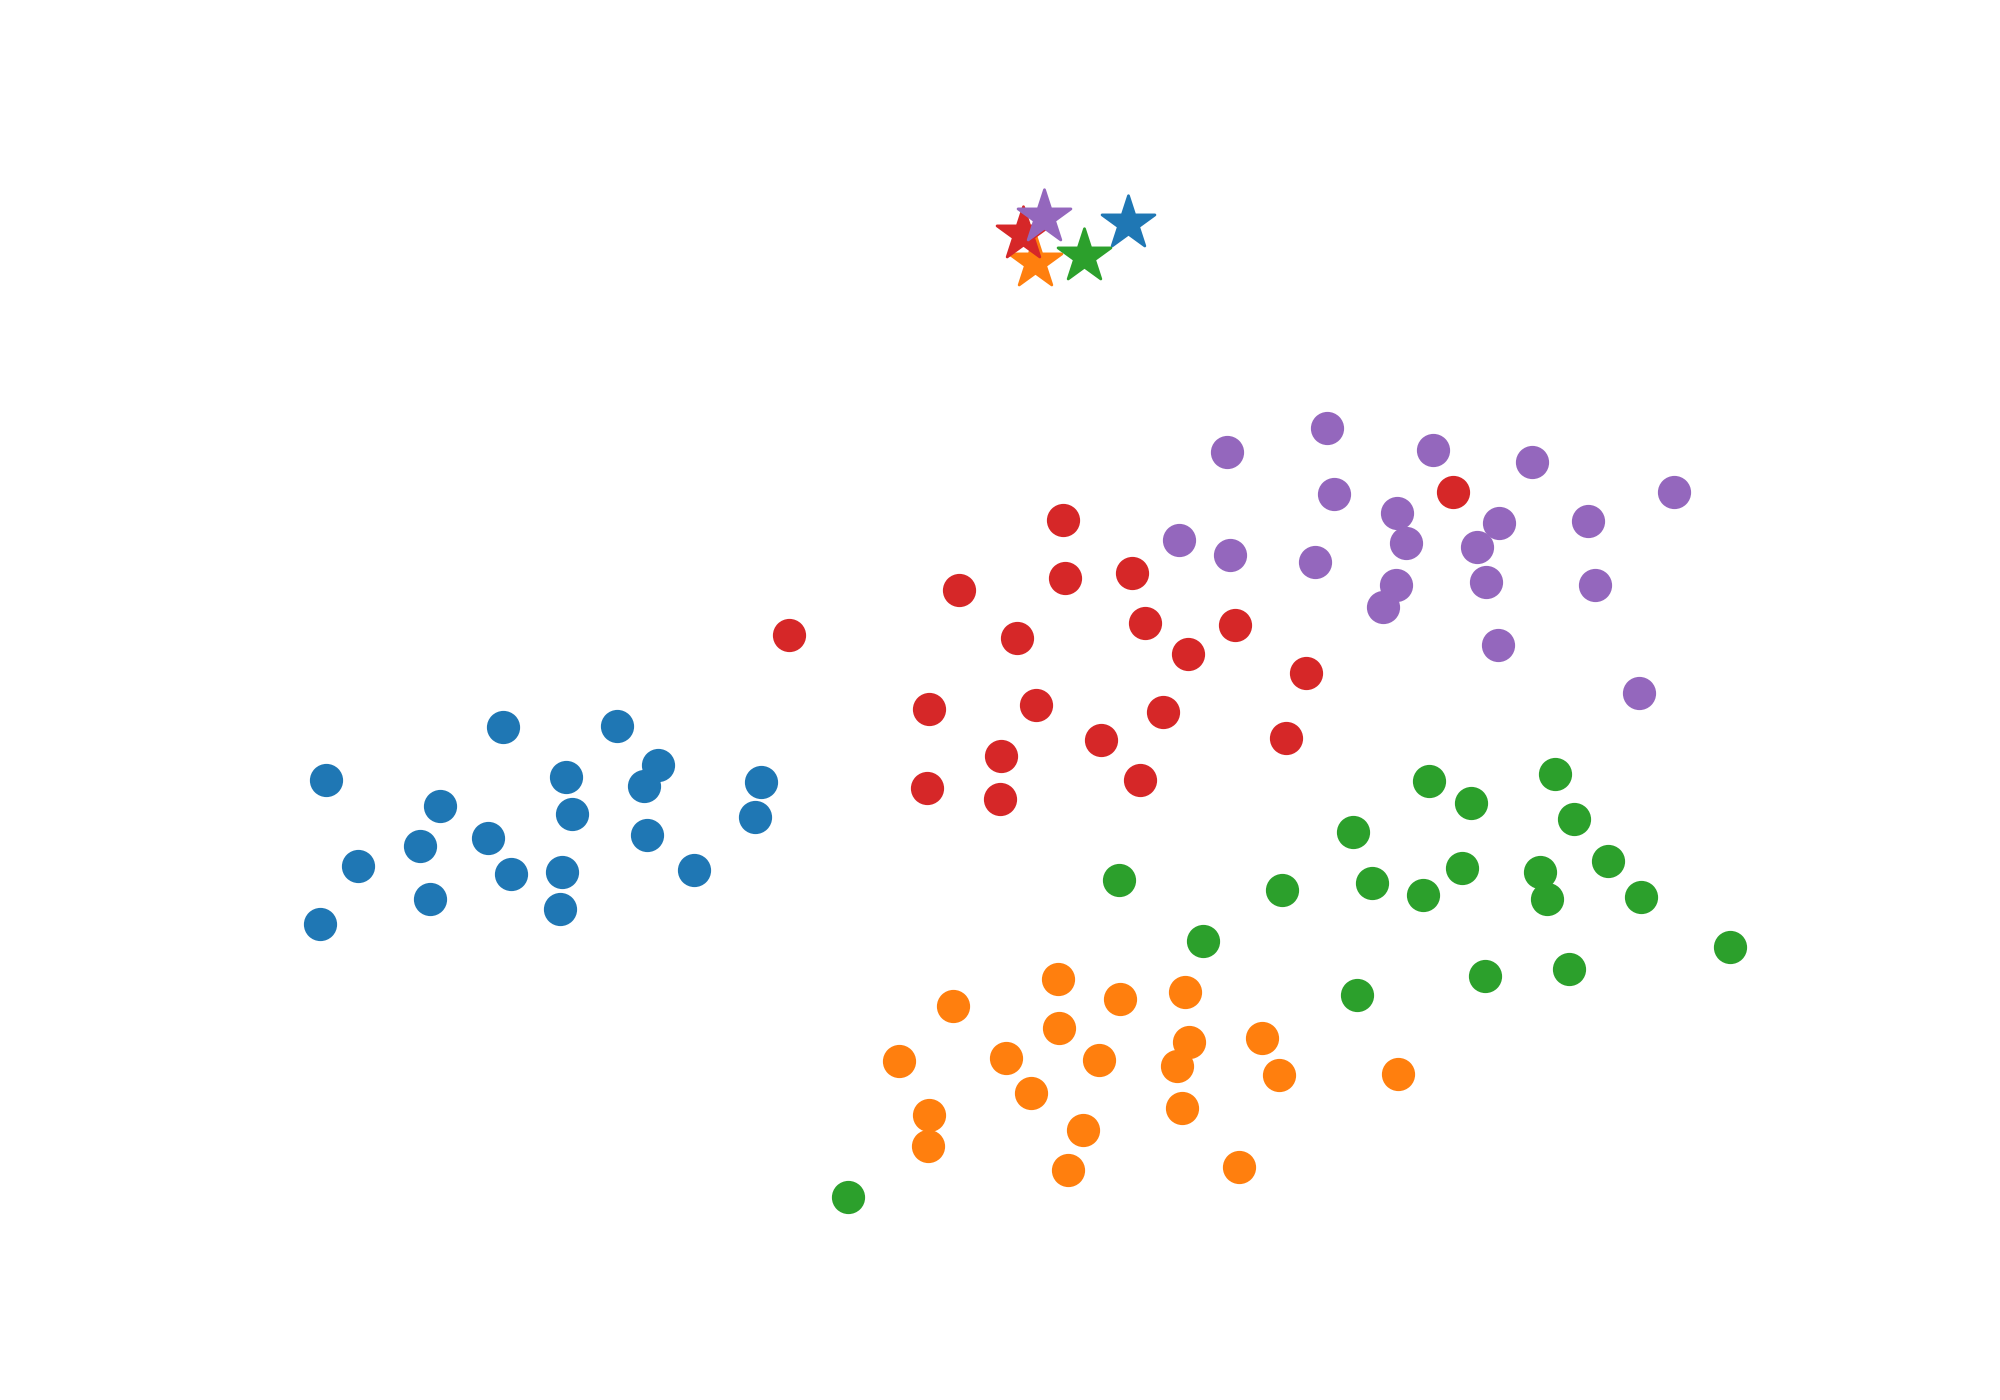

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
(0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)


In [8]:
X_2d_all = TSNE_(X, perplexity=30, n_iter_ex1=450, n_iter_ex2=50, exaggeration=12)
fig = plot_tsne(X_2d_all, K_classes, targets_selected=targets_selected, classifier_marker_size=400, feature_marker_size=120)

USING PRECOMPUTED
===> Running optimization with exaggeration=12.00, lr=8.75 for 450 iterations...
Iteration   50, KL divergence 1.4865, 50 iterations in 0.2890 sec
Iteration  100, KL divergence 1.0666, 50 iterations in 0.2720 sec
Iteration  150, KL divergence 0.9414, 50 iterations in 0.2722 sec
Iteration  200, KL divergence 0.9100, 50 iterations in 0.2726 sec
Iteration  250, KL divergence 0.8822, 50 iterations in 0.2724 sec
Iteration  300, KL divergence 0.8744, 50 iterations in 0.3707 sec
Iteration  350, KL divergence 0.8926, 50 iterations in 0.4865 sec
Iteration  400, KL divergence 0.8651, 50 iterations in 0.5481 sec
Iteration  450, KL divergence 0.8645, 50 iterations in 0.6016 sec
   --> Time elapsed: 3.39 seconds
===> Running optimization with exaggeration=1.00, lr=105.00 for 50 iterations...
Iteration   50, KL divergence -1.6631, 50 iterations in 3.7008 sec
   --> Time elapsed: 3.70 seconds
Color that is used: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)


<IPython.core.display.Javascript object>


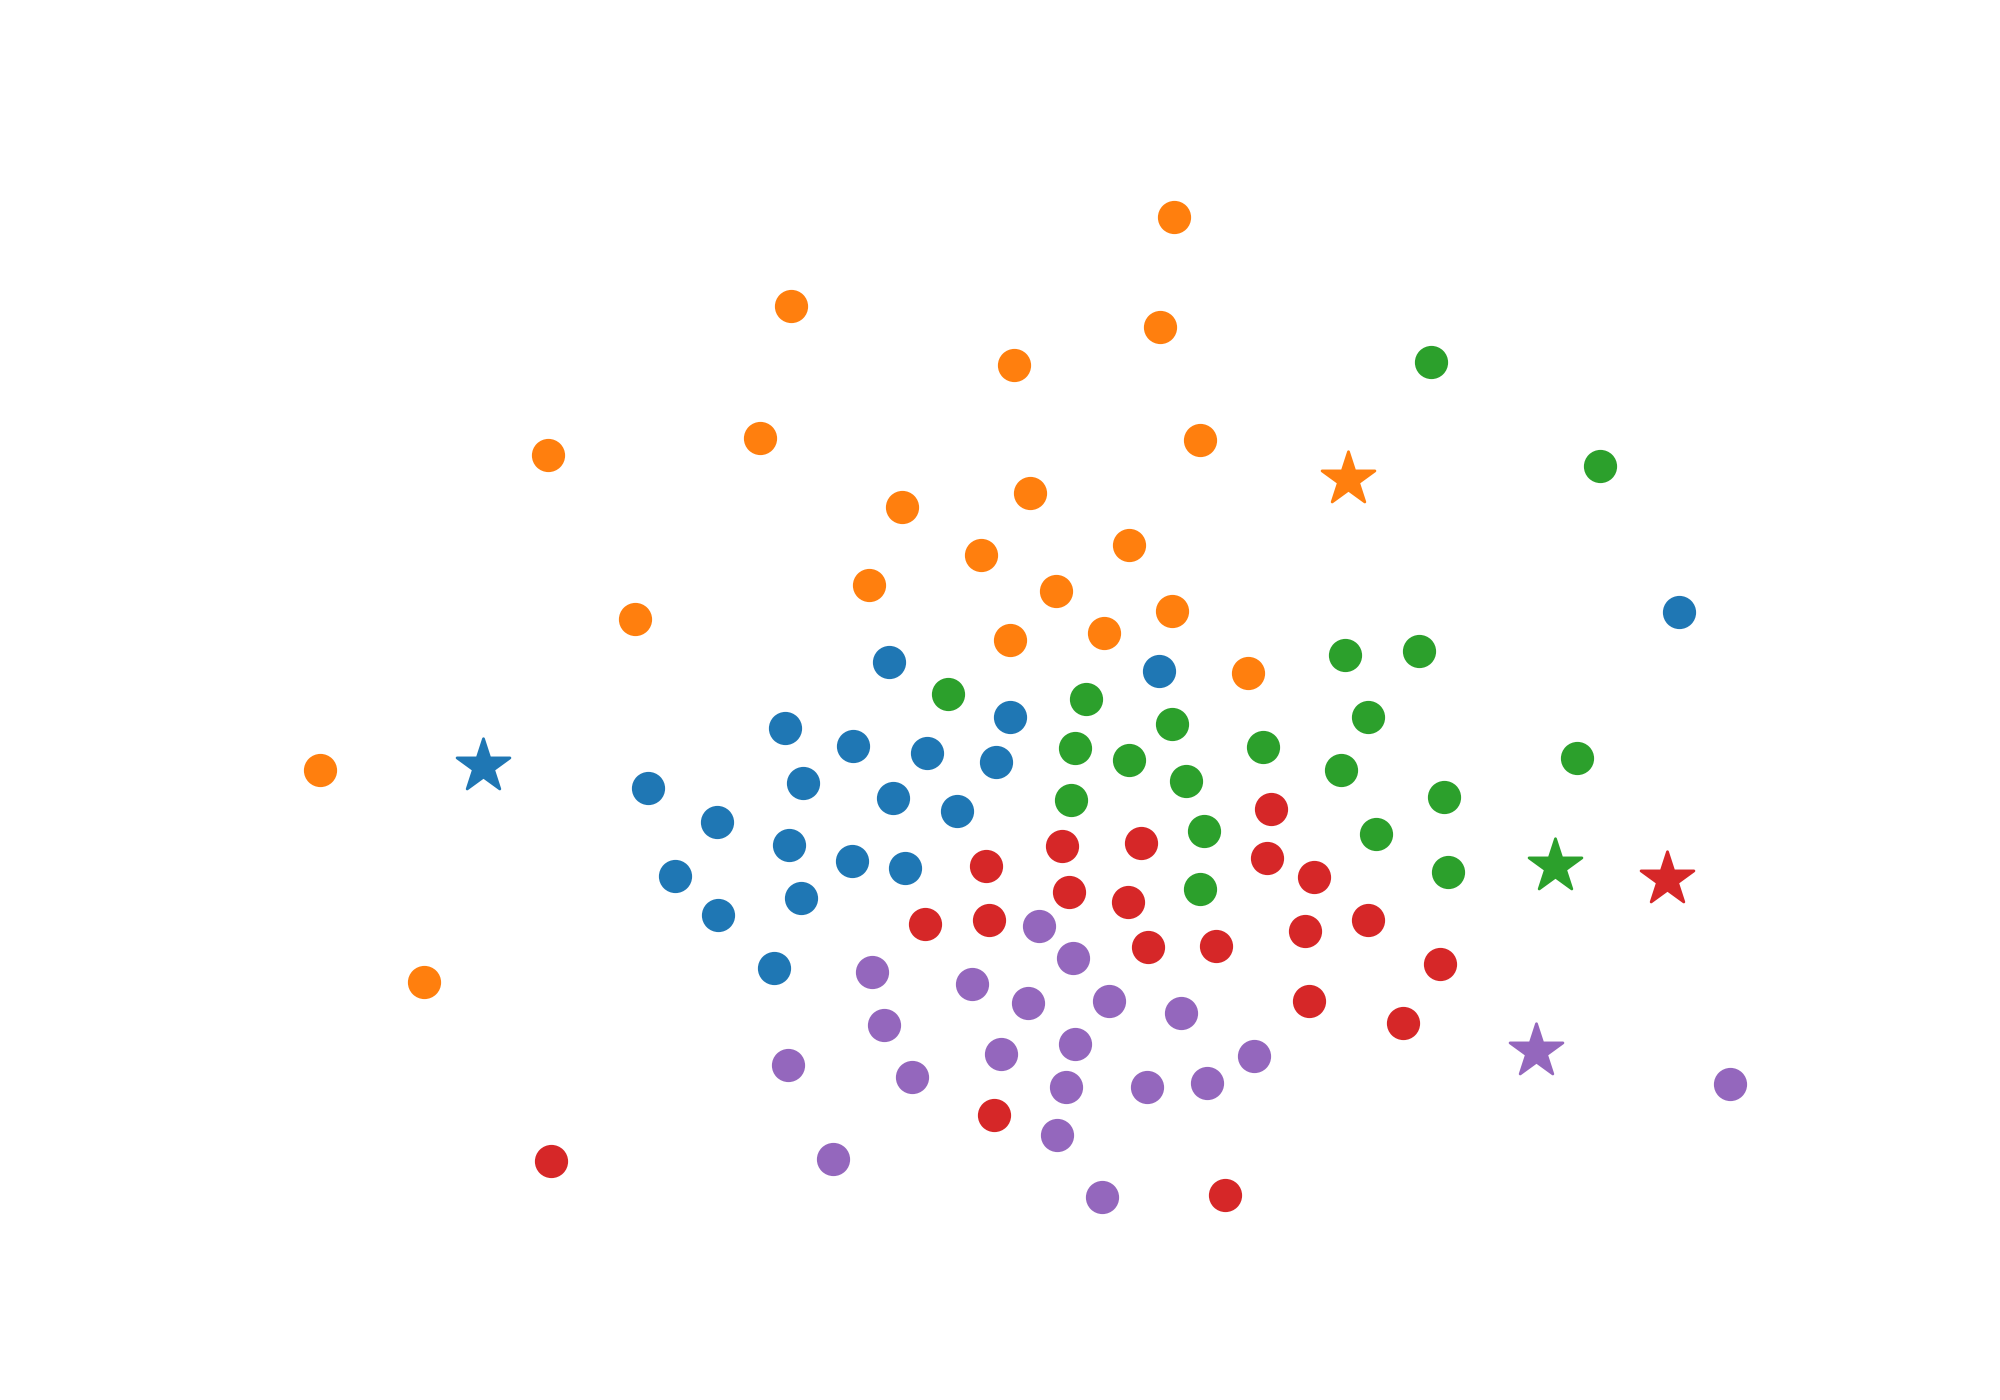

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
(0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)


In [9]:
X_2d_all = TSNE_(X, affinities=Linv_selected, normalize_affinities=True, perplexity=50, n_iter_ex1=450, n_iter_ex2=50, exaggeration=12)
fig = plot_tsne(X_2d_all, K_classes, targets_selected=targets_selected, classifier_marker_size=400, feature_marker_size=120)